## 1.Read

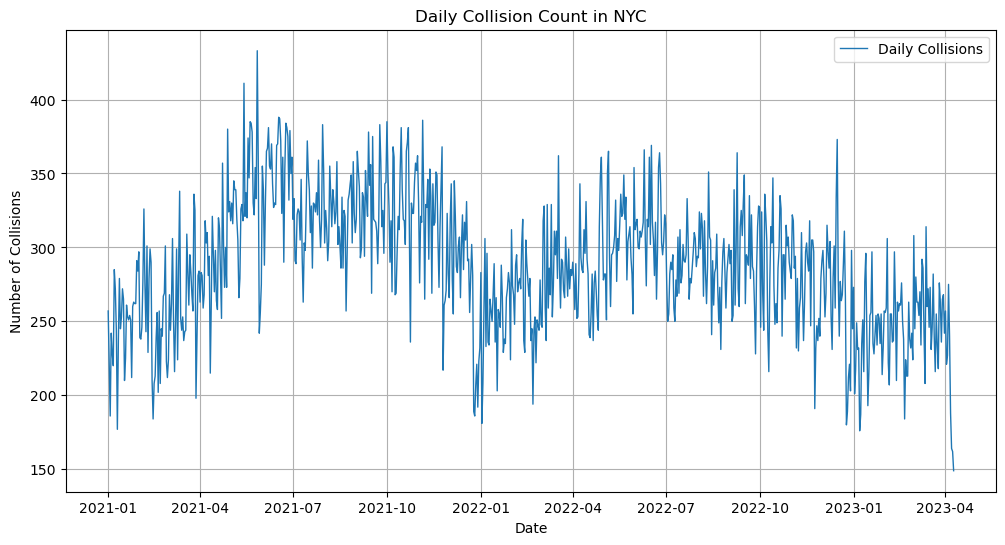

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("NYC_Collisions.csv", parse_dates=["Date"])
daily_collisions = df.groupby("Date").size().reset_index(name="Collision_Count")
plt.figure(figsize=(12, 6))
plt.plot(daily_collisions["Date"], daily_collisions["Collision_Count"], label="Daily Collisions", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.title("Daily Collision Count in NYC")
plt.legend()
plt.grid(True)
plt.show()

## 2.Preprocess

In [2]:
### 1. Time-based features ###
df["Weekday"] = df["Date"].dt.weekday
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Is_Weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 5 else 0)

### 2. Categorical variable transformation (Borough & Contributing Factor) ###
# Daily collision count by Borough
borough_counts = df.groupby(["Date", "Borough"]).size().unstack(fill_value=0)

# Daily proportion of collisions by Contributing Factor
factor_counts = df.groupby(["Date", "Contributing Factor"]).size().unstack(fill_value=0)
factor_percentages = factor_counts.div(factor_counts.sum(axis=1), axis=0).fillna(0)

### 3. Severity statistics ###
severity_stats = df.groupby("Date")[["Persons Injured", "Persons Killed", 
                                     "Pedestrians Injured", "Pedestrians Killed",
                                     "Cyclists Injured", "Cyclists Killed",
                                     "Motorists Injured", "Motorists Killed"]].sum().reset_index()

### 4. Geospatial processing ###
# Compute daily average and standard deviation of latitude/longitude
geo_features = df.groupby("Date").agg({
    "Latitude": ["mean", "std"],  
    "Longitude": ["mean", "std"]
}).fillna(0)
geo_features.columns = ["Latitude_Mean", "Latitude_Std", "Longitude_Mean", "Longitude_Std"]
geo_features = geo_features.reset_index()

# Count unique street names per day
street_counts = df.groupby("Date")["Street Name"].nunique().reset_index(name="Unique_Streets")
cross_street_counts = df.groupby("Date")["Cross Street"].nunique().reset_index(name="Unique_Cross_Streets")

### 5. Merge all features ###
final_df = (
    df.groupby("Date").size().reset_index(name="Collision_Count")  # Daily collision count
    .merge(severity_stats, on="Date", how="left")
    .merge(borough_counts, on="Date", how="left")
    .merge(factor_percentages, on="Date", how="left")
    .merge(geo_features, on="Date", how="left")
    .merge(street_counts, on="Date", how="left")
    .merge(cross_street_counts, on="Date", how="left")
)

# Add time-based features
final_df = final_df.merge(df[["Date", "Weekday", "Month", "Year", "Is_Weekend"]].drop_duplicates(), on="Date", how="left")

# Fill missing values
final_df = final_df.fillna(0)

In [9]:
final_df.columns

Index(['Date', 'Collision_Count', 'Persons Injured', 'Persons Killed',
       'Pedestrians Injured', 'Pedestrians Killed', 'Cyclists Injured',
       'Cyclists Killed', 'Motorists Injured', 'Motorists Killed', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
       'Accelerator Defective', 'Aggressive Driving/Road Rage',
       'Alcohol Involvement', 'Animals Action', 'Backing Unsafely',
       'Brakes Defective', 'Cell Phone (hand-Held)', 'Cell Phone (hands-free)',
       'Driver Inattention/Distraction', 'Driver Inexperience',
       'Driverless/Runaway Vehicle', 'Drugs (illegal)', 'Eating or Drinking',
       'Failure to Keep Right', 'Failure to Yield Right-of-Way',
       'Fatigued/Drowsy', 'Fell Asleep', 'Following Too Closely', 'Glare',
       'Headlights Defective', 'Illnes', 'Lane Marking Improper/Inadequate',
       'Listening/Using Headphones', 'Lost Consciousness',
       'Obstruction/Debris', 'Other Electronic Device',
       'Other Lighting Defects', 'Ot

## 3.EDA

/Users/easonwang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


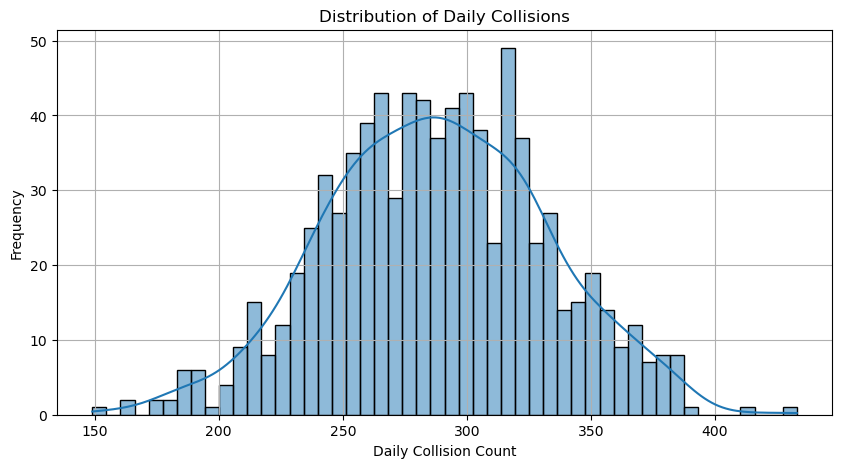

In [3]:
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
import geopandas as gpd
from shapely.geometry import Point

# Load preprocessed data
df = final_df.copy()

### 1. Statistical Analysis ###
# Distribution of daily collisions
plt.figure(figsize=(10, 5))
sns.histplot(df["Collision_Count"], bins=50, kde=True)
plt.xlabel("Daily Collision Count")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Collisions")
plt.grid(True)
plt.show()

In [10]:
# Summary statistics
df.describe()

,Date,Collision_Count,Persons Injured,Persons Killed,Pedestrians Injured,Pedestrians Killed,Cyclists Injured,Cyclists Killed,Motorists Injured,Motorists Killed,...,Latitude_Mean,Latitude_Std,Longitude_Mean,Longitude_Std,Unique_Streets,Unique_Cross_Streets,Weekday,Month,Year,Is_Weekend
count,829,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,...,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000
mean,2022-02-19 00:00:00.000000256,287.600724,140.200241,0.765983,22.770808,0.344994,13.186972,0.056695,98.224367,0.323281,...,40.724433,0.081719,-73.916533,0.083994,230.480097,124.329312,3.007238,6.007238,2021.679131,0.287093
min,2021-01-01 00:00:00,149.000000,38.000000,0.000000,3.000000,0.000000,0.000000,0.000000,32.000000,0.000000,...,40.699682,0.069241,-73.933602,0.067305,130.000000,55.000000,0.000000,1.000000,2021.000000,0.000000
25%,2021-07-27 00:00:00,257.000000,119.000000,0.000000,17.000000,0.000000,8.000000,0.000000,83.000000,0.000000,...,40.721070,0.079541,-73.920638,0.080610,210.000000,111.000000,1.000000,3.000000,2021.000000,0.000000
50%,2022-02-19 00:00:00,287.000000,142.000000,1.000000,22.000000,0.000000,13.000000,0.000000,98.000000,0.000000,...,40.724532,0.081674,-73.916749,0.083814,231.000000,124.000000,3.000000,6.000000,2022.000000,0.000000
75%,2022-09-14 00:00:00,319.000000,162.000000,1.000000,28.000000,1.000000,18.000000,0.000000,114.000000,1.000000,...,40.728206,0.083863,-73.912498,0.087288,253.000000,137.000000,5.000000,9.000000,2022.000000,1.000000
max,2023-04-09 00:00:00,433.000000,234.000000,5.000000,83.000000,3.000000,35.000000,1.000000,170.000000,4.000000,...,40.743245,0.097983,-73.896559,0.103580,317.000000,180.000000,6.000000,12.000000,2023.000000,1.000000
std,NaN,44.177792,30.502094,0.941912,8.783250,0.595202,6.256400,0.231398,22.369597,0.632609,...,0.005732,0.003132,0.005910,0.005205,31.079781,20.124705,2.001798,3.547122,0.676244,0.452678


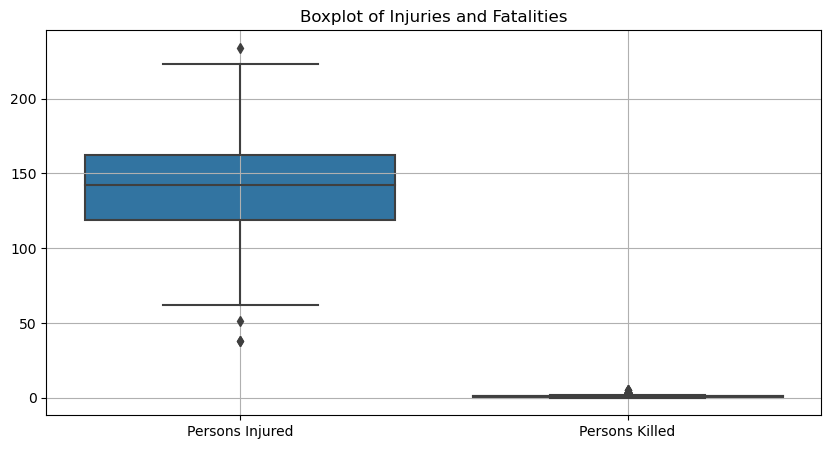

In [11]:
# Boxplot for accident severity
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Persons Injured", "Persons Killed"]])
plt.title("Boxplot of Injuries and Fatalities")
plt.grid(True)
plt.show()


Stationary Columns:
['Persons Killed', 'Pedestrians Injured', 'Pedestrians Killed', 'Cyclists Killed', 'Motorists Killed', 'Staten Island', 'Accelerator Defective', 'Aggressive Driving/Road Rage', 'Alcohol Involvement', 'Animals Action', 'Backing Unsafely', 'Brakes Defective', 'Cell Phone (hand-Held)', 'Cell Phone (hands-free)', 'Driver Inattention/Distraction', 'Driver Inexperience', 'Driverless/Runaway Vehicle', 'Drugs (illegal)', 'Eating or Drinking', 'Failure to Keep Right', 'Failure to Yield Right-of-Way', 'Fatigued/Drowsy', 'Fell Asleep', 'Following Too Closely', 'Glare', 'Headlights Defective', 'Illnes', 'Lane Marking Improper/Inadequate', 'Listening/Using Headphones', 'Lost Consciousness', 'Obstruction/Debris', 'Other Electronic Device', 'Other Lighting Defects', 'Other Vehicular', 'Outside Car Distraction', 'Oversized Vehicle', 'Passenger Distraction', 'Passing Too Closely', 'Passing or Lane Usage Improper', 'Pavement Defective', 'Pavement Slippery', 'Pedestrian/Bicyclist/Oth

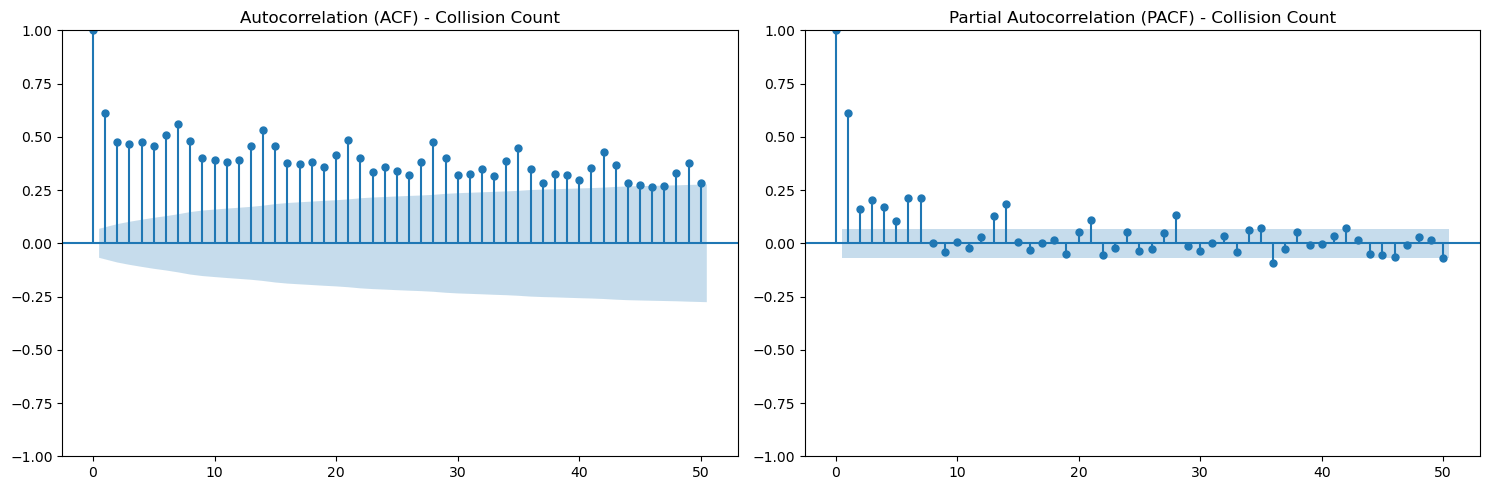

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### 3. Time Series Stationarity Analysis ###
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and return stationarity status
def adf_test(series, label):
    result = adfuller(series.dropna())
    is_stationary = result[1] <= 0.05  # Stationary if p-value <= 0.05
    return is_stationary

# Apply ADF test to all numeric columns
stationary_columns = []

for column in df.select_dtypes(include=["number"]).columns:
    if column != "Date":  # Ensure 'Date' column is excluded
        if adf_test(df[column], column):
            stationary_columns.append(column)

# Output list of stationary columns
print("\nStationary Columns:")
print(stationary_columns)

# Plot ACF and PACF for Collision Count
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df["Collision_Count"], lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF) - Collision Count")

plot_pacf(df["Collision_Count"], lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF) - Collision Count")

plt.tight_layout()
plt.show()


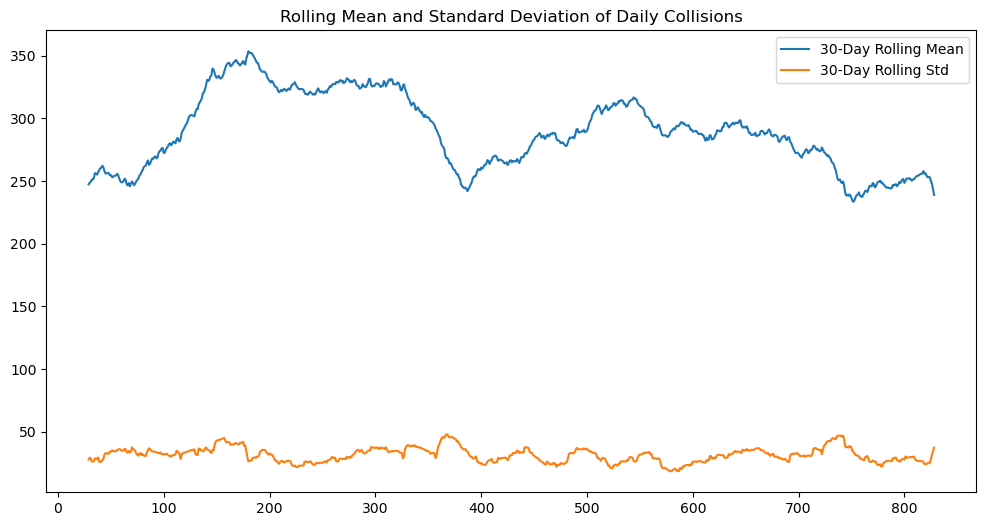

In [17]:
# Rolling mean & standard deviation
plt.figure(figsize=(12, 6))
df["Collision_Count"].rolling(window=30).mean().plot(label="30-Day Rolling Mean")
df["Collision_Count"].rolling(window=30).std().plot(label="30-Day Rolling Std")
plt.legend()
plt.title("Rolling Mean and Standard Deviation of Daily Collisions")
plt.show()

<Figure size 800x800 with 0 Axes>

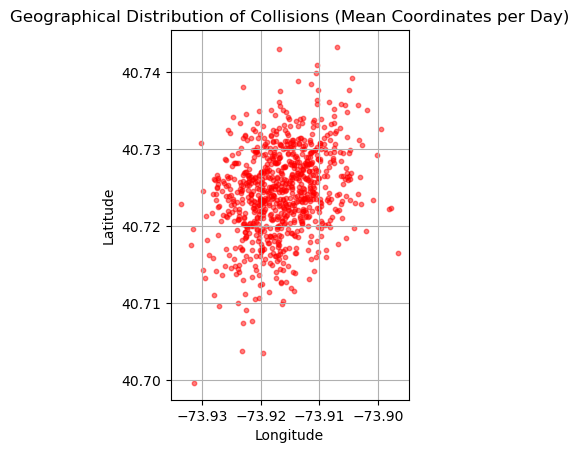

In [18]:
### 4. Geospatial Distribution ###
# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Longitude_Mean"], df["Latitude_Mean"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# NYC boundary (Optional: Download shapefile from an open-source dataset)
# nyc_map = gpd.read_file("nyc_shapefile.shp")

plt.figure(figsize=(8, 8))
gdf.plot(marker="o", color="red", alpha=0.5, markersize=10)
plt.title("Geographical Distribution of Collisions (Mean Coordinates per Day)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

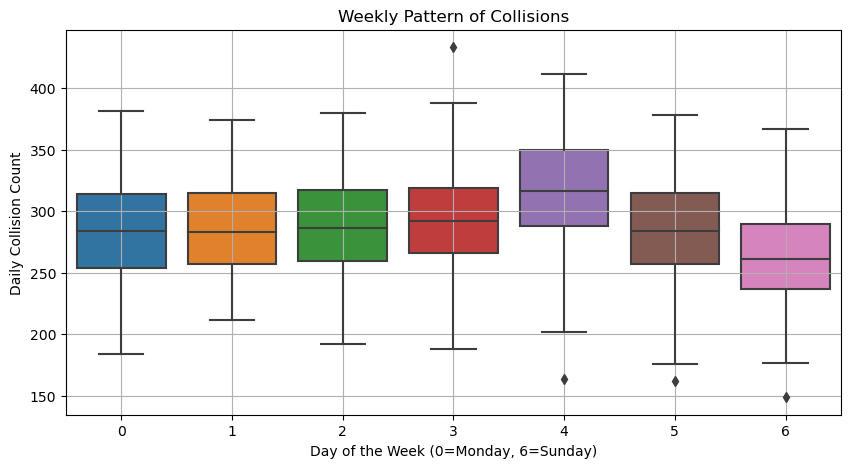

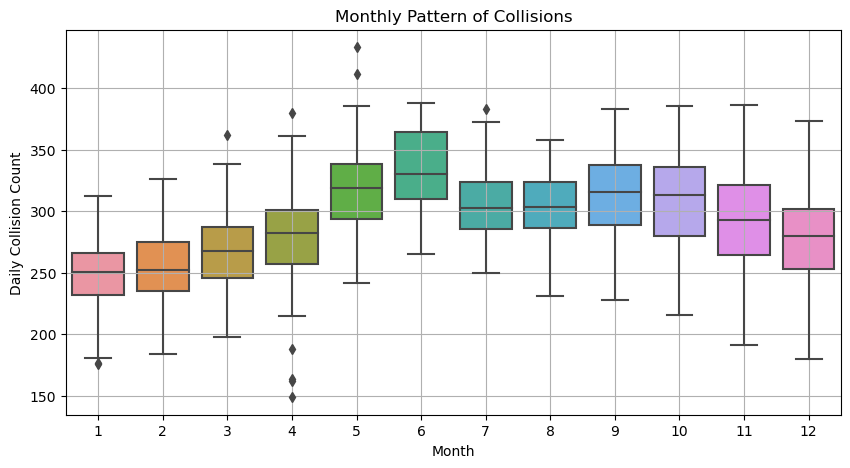

In [19]:
### 5. Weekly & Monthly Trends ###
df["Weekday"] = df["Date"].dt.weekday
df["Month"] = df["Date"].dt.month

# Weekly pattern
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Weekday"], y=df["Collision_Count"])
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Daily Collision Count")
plt.title("Weekly Pattern of Collisions")
plt.grid(True)
plt.show()

# Monthly pattern
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Month"], y=df["Collision_Count"])
plt.xlabel("Month")
plt.ylabel("Daily Collision Count")
plt.title("Monthly Pattern of Collisions")
plt.grid(True)
plt.show()

## 4.Modeling

ADF Test for Differenced Collision Count:
ADF Statistic: -9.6262
p-value: 0.0000
Critical Values: {'1%': -3.4384690549764856, '5%': -2.8651236651346306, '10%': -2.568678262976669}
Differenced Collision Count is likely stationary (Reject H0)
--------------------------------------------------


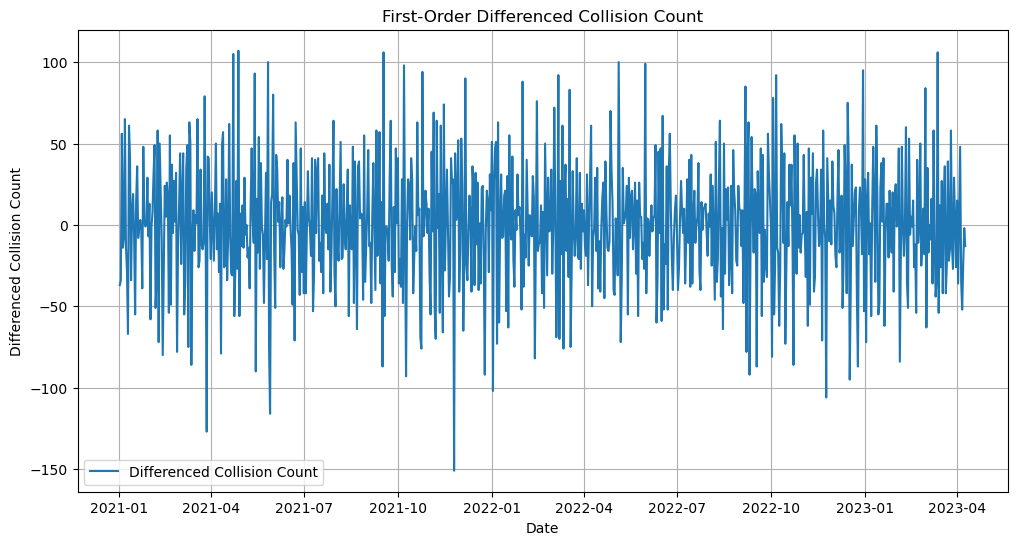

In [4]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# First-order differencing
df["Collision_Count_Diff"] = df["Collision_Count"].diff()

# ADF test on differenced series
def adf_test(series, label):
    result = adfuller(series.dropna())
    print(f"ADF Test for {label}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print(f"{label} is likely stationary (Reject H0)")
    else:
        print(f"{label} is likely non-stationary (Fail to reject H0)")
    print("-" * 50)

adf_test(df["Collision_Count_Diff"], "Differenced Collision Count")

# Plot the transformed series
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Collision_Count_Diff"], label="Differenced Collision Count")
plt.xlabel("Date")
plt.ylabel("Differenced Collision Count")
plt.title("First-Order Differenced Collision Count")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x500 with 0 Axes>

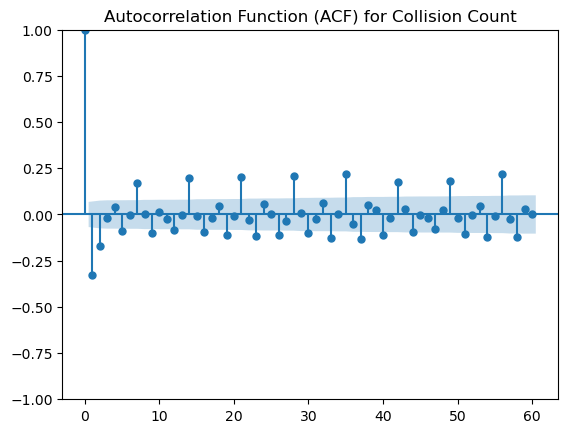

In [18]:
plt.figure(figsize=(10, 5))
plot_acf(df["Collision_Count_Diff"].dropna(), lags=60)  # Check up to 60 lags
plt.title("Autocorrelation Function (ACF) for Collision Count")
plt.show()

### SARIMA

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Auto ARIMA model selection
sarima_model = auto_arima(train["Collision_Count_Diff"].dropna(), 
                          seasonal=True, m=7,  # Weekly seasonality
                          trace=True, stepwise=True, suppress_warnings=True, 
                          max_p=3, max_q=3, max_P=2, max_Q=2, 
                          max_d=2, max_D=2, information_criterion="aicc")

print(f"\nOptimal SARIMA Order: {sarima_model.order}")
print(f"Optimal Seasonal Order: {sarima_model.seasonal_order}")

p, d, q = sarima_model.order
P, D, Q, s = sarima_model.seasonal_order

best_sarima = SARIMAX(train["Collision_Count_Diff"].dropna(), 
                      order=(p, d, q), 
                      seasonal_order=(P, D, Q, s), 
                      enforce_stationarity=False, enforce_invertibility=False)

sarima_results = best_sarima.fit()
print(sarima_results.summary())

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AICC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AICC=6731.235, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AICC=6625.665, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AICC=6473.680, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AICC=6729.224, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AICC=6490.768, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AICC=inf, Time=0.47 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AICC=6458.627, Time=0.31 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AICC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AICC=6705.349, Time=0.22 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AICC=6435.435, Time=0.35 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AICC=6448.995, Time=0.17 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AICC=inf, Time=0.91 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AICC=inf, Time=0.54 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AICC=

/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:              Collision_Count_Diff   No. Observations:                  662
Model:             SARIMAX(0, 0, 2)x(0, 0, 2, 7)   Log Likelihood               -3130.639
Date:                           Sun, 23 Feb 2025   AIC                           6271.277
Time:                                   10:48:55   BIC                           6293.624
Sample:                                        0   HQIC                          6279.948
                                           - 662                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6922      0.038    -18.401      0.000      -0.766      -0.618
ma.L2         -0.2016      0.035     -5.684

Test RMSE: 50.5471
Model AIC: 6271.2773, AICc: 6271.3687


/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


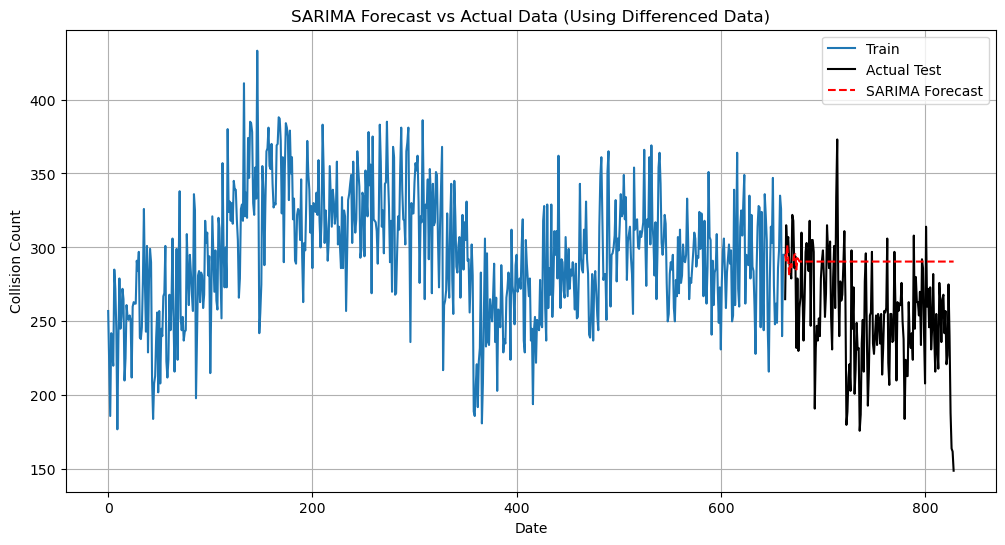

In [8]:
# Forecast on test set
test_predictions = sarima_results.get_forecast(steps=len(test))
predicted_diff = test_predictions.predicted_mean
predicted_original = df["Collision_Count"].iloc[train_size-1] + np.cumsum(predicted_diff)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test["Collision_Count"], predicted_original))
print(f"Test RMSE: {rmse:.4f}")

# Compute AICc (corrected AIC)
aic = sarima_results.aic
n = len(train["Collision_Count_Diff"].dropna())
k = len(sarima_results.params)
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
print(f"Model AIC: {aic:.4f}, AICc: {aicc:.4f}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Collision_Count"], label="Train")
plt.plot(test.index, test["Collision_Count"], label="Actual Test", color="black")
plt.plot(test.index, predicted_original, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Collision Count")
plt.title("SARIMA Forecast vs Actual Data (Using Differenced Data)")
plt.legend()
plt.grid(True)
plt.show()

### ARFIMA

In [9]:
arfima_model = auto_arima(train["Collision_Count"].dropna(), 
                          seasonal=True, m=7,  # Let auto_arima determine if weekly seasonality exists
                          start_p=1, start_q=1, d=None, 
                          start_P=1, start_Q=1, D=1,
                          trace=True, stepwise=True, suppress_warnings=True)

print(f"\nOptimal ARFIMA Order: {arfima_model.order}")
print(f"Optimal Seasonal Order: {arfima_model.seasonal_order}")

arfima_results = arfima_model.fit(train["Collision_Count_Diff"].dropna())

print(arfima_results.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6703.671, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6494.330, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6390.174, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6701.853, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=6673.924, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=6391.599, Time=0.30 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=6391.558, Time=0.55 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=6501.566, Time=0.24 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=6393.081, Time=1.30 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=6451.866, Time=0.13 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=6372.232, Time=0.35 sec
 ARIMA(0,0,2)(0,1,0)[7] intercept   : AIC=6674.142, Time=0.19 sec
 ARIMA(0,0,2)(1,1,1)[7] intercept   : AIC=6

Test RMSE: 56.6543
Model AIC: 6265.5623, AICc: 6265.7335


/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


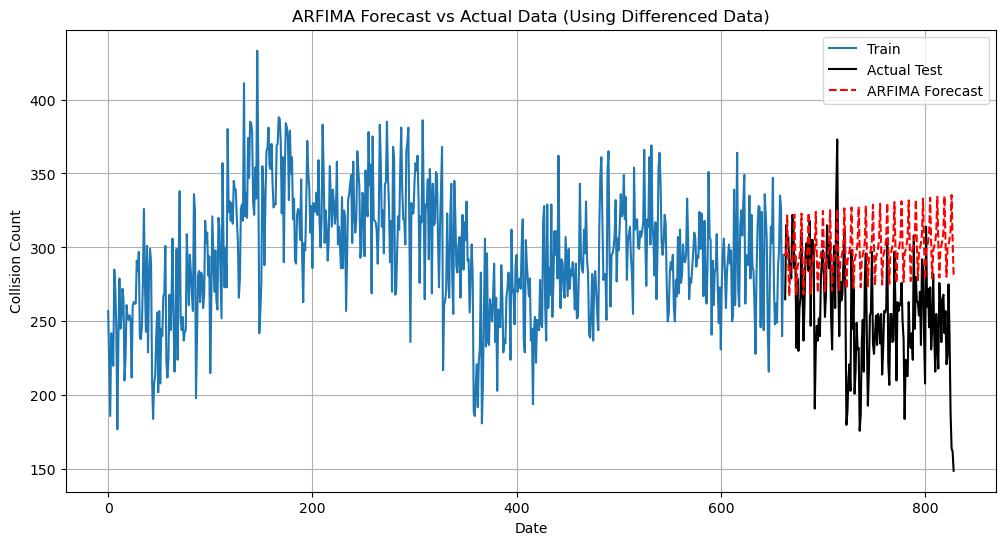

In [10]:
# Forecast on test set
future_steps = len(test)
forecast_diff = arfima_results.predict(n_periods=future_steps)

# Convert differenced forecast back to original scale
predicted_original = df["Collision_Count"].iloc[train_size-1] + np.cumsum(forecast_diff)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test["Collision_Count"], predicted_original))
print(f"Test RMSE: {rmse:.4f}")

# Compute AICc (corrected AIC)
aic = arfima_results.aic()
n = len(train["Collision_Count_Diff"].dropna())
k = len(arfima_results.params())
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
print(f"Model AIC: {aic:.4f}, AICc: {aicc:.4f}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Collision_Count"], label="Train")
plt.plot(test.index, test["Collision_Count"], label="Actual Test", color="black")
plt.plot(test.index, predicted_original, label="ARFIMA Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Collision Count")
plt.title("ARFIMA Forecast vs Actual Data (Using Differenced Data)")
plt.legend()
plt.grid(True)
plt.show()

### VAR

In [16]:
# Select stationary features + differenced collision count
selected_features = ['Latitude_Mean', 'Latitude_Std', 'Longitude_Mean', 'Longitude_Std', 'Is_Weekend']

train_var = train[["Collision_Count_Diff"] + selected_features].dropna()
test_var = test[["Collision_Count_Diff"] + selected_features].dropna()

from statsmodels.tsa.api import VAR

# Find optimal lag order
model = VAR(train_var)
lag_selection = model.select_order(maxlags=15)
print(lag_selection.summary())

# Select best lag based on AIC/BIC
optimal_lag = lag_selection.aic  # Choose lag with lowest AIC

# Fit VAR model with optimal lag
var_model = VAR(train_var)
var_results = var_model.fit(optimal_lag)

print(var_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -37.81      -37.77   3.783e-17      -37.80
1       -38.17      -37.88   2.639e-17      -38.06
2       -38.59      -38.05   1.735e-17      -38.38
3       -38.68      -37.89   1.592e-17      -38.37
4       -39.20      -38.16   9.446e-18      -38.80
5       -40.31      -39.02   3.131e-18      -39.81
6       -98.92      -97.38   1.098e-43      -98.32
7       -100.4      -98.60   2.529e-44      -99.70
8      -102.5*     -100.5*  2.917e-45*     -101.8*
9       -99.78      -97.50   4.644e-44      -98.90
10      -99.71      -97.18   4.984e-44      -98.73
11      -98.51      -95.73   1.657e-43      -97.43
12      -97.96      -94.93   2.875e-43      -96.79
13      -99.05      -95.77   9.717e-44      -97.78
14      -98.23      -94.70   2.209e-43      -96.86
15      -98.99      -95.22   1.031e-43      -97.53
-------------------------------

/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/easonwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test RMSE: 34.0097
VAR Model AIC: -101.7011
VAR Model AICc: -93.6946


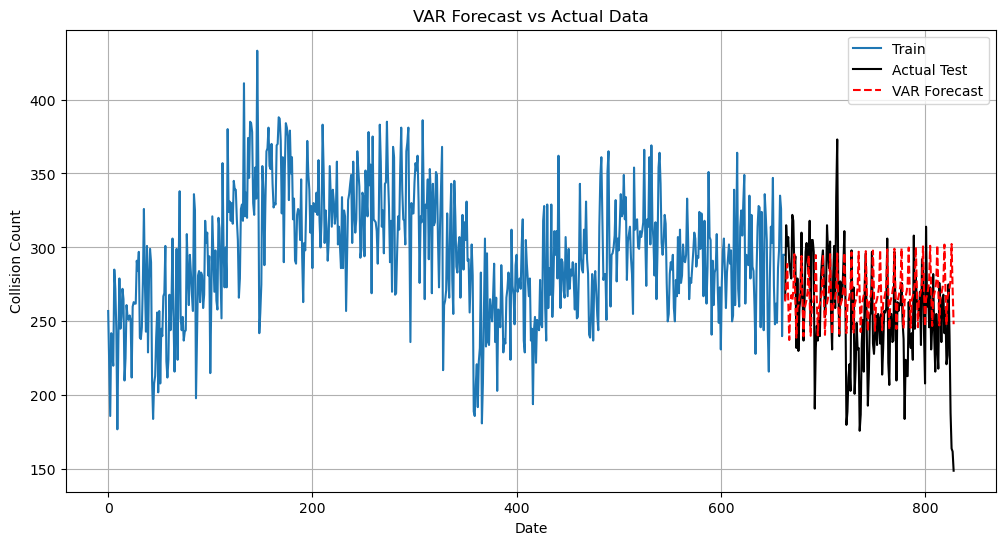

In [17]:
# Forecast for test set
forecast_steps = len(test_var)
forecast_diff = var_results.forecast(train_var.values[-optimal_lag:], steps=forecast_steps)

# Convert forecasted differenced values back to original scale
forecast_original = test["Collision_Count"].iloc[0] + np.cumsum(forecast_diff[:, 0])

# Compute RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_var["Collision_Count_Diff"], forecast_diff[:, 0]))
print(f"Test RMSE: {rmse:.4f}")

# Compute AIC for the fitted VAR model
aic = var_results.aic
n = len(train_var)  # Number of observations
k = len(var_results.params)  # Number of parameters

aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

print(f"VAR Model AIC: {aic:.4f}")
print(f"VAR Model AICc: {aicc:.4f}")
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Collision_Count"], label="Train")
plt.plot(test.index, test["Collision_Count"], label="Actual Test", color="black")
plt.plot(test.index[:forecast_steps], forecast_original, label="VAR Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Collision Count")
plt.title("VAR Forecast vs Actual Data")
plt.legend()
plt.grid(True)
plt.show()

### PCA

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

# Ensure Collision_Count_Diff is computed
final_df["Collision_Count_Diff"] = final_df["Collision_Count"].diff().fillna(0)
final_df = final_df.select_dtypes(include=["number"])

# Separate dependent and independent variables
y = final_df[["Collision_Count_Diff"]]  # Dependent variables
X = final_df.drop(columns=["Collision_Count", "Collision_Count_Diff"])  # Independent variables

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA and retain components explaining 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for principal components
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=final_df.index)

# Create a mapping of original variables to principal components (PCA loadings)
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=pca_columns)

In [31]:
pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61
Persons Injured,0.311730,0.151624,-0.132024,-0.000632,-0.067167,0.002150,0.012056,-0.005446,-0.021129,-0.024469,...,0.014707,0.011431,0.000080,0.108246,-0.032718,0.012813,-0.130977,0.059768,0.043220,0.109687
Persons Killed,0.049847,0.096217,-0.110891,-0.044441,0.624705,0.059518,0.057627,0.033430,-0.040531,-0.022570,...,0.042689,-0.055790,-0.032180,-0.001899,-0.004613,-0.010681,-0.042880,-0.036094,-0.021601,-0.028934
Pedestrians Injured,0.169508,-0.168374,-0.177518,-0.048496,-0.054694,0.262364,-0.089691,0.197691,0.005511,-0.075113,...,-0.038214,0.025739,-0.042653,-0.042009,0.008651,-0.071997,0.085300,-0.042610,0.116719,0.048098
Pedestrians Killed,0.026900,0.018362,-0.048197,-0.055040,0.419044,0.081951,-0.029802,0.139991,-0.021354,0.006148,...,-0.013220,-0.089317,0.009928,0.011383,0.156251,-0.002452,-0.079877,-0.200286,-0.021590,0.061726
Cyclists Injured,0.259078,0.076091,-0.099721,-0.052769,-0.020322,-0.104526,0.001797,-0.148533,-0.018926,0.037341,...,0.035822,0.053188,0.026747,0.063815,0.049247,0.019914,-0.118209,-0.000280,-0.010657,-0.033284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unique_Cross_Streets,0.336072,0.028958,0.057599,0.066973,-0.017019,0.005504,-0.051367,0.071016,-0.021420,-0.060670,...,-0.035370,0.028418,-0.012514,-0.014404,0.033889,-0.008403,0.066812,-0.068735,0.026575,0.000656
Weekday,-0.077759,0.375002,-0.048770,0.058342,-0.074133,0.064895,0.008431,0.078591,-0.055059,-0.072473,...,-0.011813,-0.068684,0.037670,-0.105105,0.139519,-0.074611,0.083098,0.047075,-0.078013,0.085886
Month,0.162935,0.083360,-0.101245,0.039490,0.030573,0.095098,-0.135403,-0.149216,0.169622,0.151991,...,0.086037,-0.055344,0.114783,-0.052040,0.117351,-0.088055,0.074897,0.103966,-0.192269,0.012584
Year,-0.114186,-0.102421,-0.367815,-0.073020,-0.115020,0.040028,0.056332,0.113992,-0.086545,-0.098554,...,-0.018711,-0.163481,-0.067627,-0.021783,0.070096,0.037035,-0.122536,0.039677,0.214261,0.089597


In [32]:
# Select the first 8 principal components as independent variables
selected_pca_components = X_pca_df.iloc[:, :8]

# Perform ADF test for each selected PCA component
stationary_pcs = []
adf_results = {}

for col in selected_pca_components.columns:
    result = adfuller(selected_pca_components[col].dropna())
    adf_results[col] = {"ADF Statistic": result[0], "p-value": result[1]}
    if result[1] <= 0.05:
        stationary_pcs.append(col)


In [12]:
adf_results

{'PC1': {'ADF Statistic': -1.9080132874110631, 'p-value': 0.32830084858413133},
 'PC2': {'ADF Statistic': -1.6393073807385357, 'p-value': 0.46262272945914046},
 'PC3': {'ADF Statistic': -1.4329829799116185, 'p-value': 0.566365549768816},
 'PC4': {'ADF Statistic': -6.968714361268182,
  'p-value': 8.777362142473856e-10},
 'PC5': {'ADF Statistic': -7.936379500171908,
  'p-value': 3.4048108153500193e-12},
 'PC6': {'ADF Statistic': -5.963444072898162,
  'p-value': 2.0135954905186092e-07},
 'PC7': {'ADF Statistic': -17.878661890374534,
  'p-value': 3.00828878187971e-30},
 'PC8': {'ADF Statistic': -4.515587800737716,
  'p-value': 0.00018427287343544322}}

In [33]:
diff_pca_components = X_pca_df[["PC1", "PC2", "PC3"]].diff().dropna()
# Merge differenced PC1-PC3 with already stationary PC4-PC8
final_selected_pcs = pd.concat([diff_pca_components, X_pca_df[["PC4", "PC5", "PC6", "PC7", "PC8"]]], axis=1).dropna()
for col in final_selected_pcs.columns:
    result = adfuller(final_selected_pcs[col].dropna())
    adf_results[col] = {"ADF Statistic": result[0], "p-value": result[1]}
    if result[1] <= 0.05:
        stationary_pcs.append(col)


In [25]:
final_selected_pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
1,-0.024100,-2.404620,0.521408,-0.930956,0.567207,0.536901,1.439389,-0.047494
2,-2.330541,0.268722,-0.812087,-0.402754,-1.361078,0.202841,0.433368,-0.859212
3,3.402422,-2.587525,2.050474,-1.946513,1.879229,-1.771383,-0.527006,0.688316
4,-1.221765,-0.869304,0.756776,0.737798,0.491000,-2.640254,1.837296,-1.070215
5,-0.070113,-0.327968,0.290885,-1.289402,2.435029,-1.251338,1.704225,-0.916922
...,...,...,...,...,...,...,...,...
824,-2.188423,0.569894,-0.430814,0.899663,2.753512,1.542672,1.607093,-1.249057
825,-3.614465,-2.041430,0.344423,1.675189,-0.665866,-2.486423,-0.027031,-0.856510
826,-0.327926,1.210844,1.085594,0.042911,-0.843521,-1.828920,0.720138,-1.474059
827,-1.283455,2.948380,-0.726883,-0.732444,-1.453887,-0.657699,-0.437568,-2.586764


In [34]:
y = y.iloc[1:]

In [35]:
y

,Collision_Count_Diff
1,-37.0
2,-34.0
3,56.0
4,-14.0
5,-8.0
...,...
824,-35.0
825,-52.0
826,-24.0
827,-2.0


In [36]:
# Concatenate dependent and independent variables, dropping NaN values
data = pd.concat([y, final_selected_pcs], axis=1).dropna()

In [39]:
from statsmodels.tsa.api import VAR
# Train-test split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Find optimal lag order
model = VAR(train)
lag_selection = model.select_order(maxlags=15)
optimal_lag = lag_selection.aic  # Choose lag with lowest AIC

# Fit VAR model with optimal lag
var_model = VAR(train)
var_results = var_model.fit(optimal_lag)

print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Feb, 2025
Time:                     11:47:49
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    13.0873
Nobs:                     655.000    HQIC:                   10.6727
Log likelihood:          -10783.1    FPE:                    9406.50
AIC:                      9.14353    Det(Omega_mle):         4064.81
--------------------------------------------------------------------
Results for equation Collision_Count_Diff
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.199461         1.153183            0.173           0.863
L1.Collision_Count_Diff        -0.796802         0.126760           -6.286           0.000
L1.PC

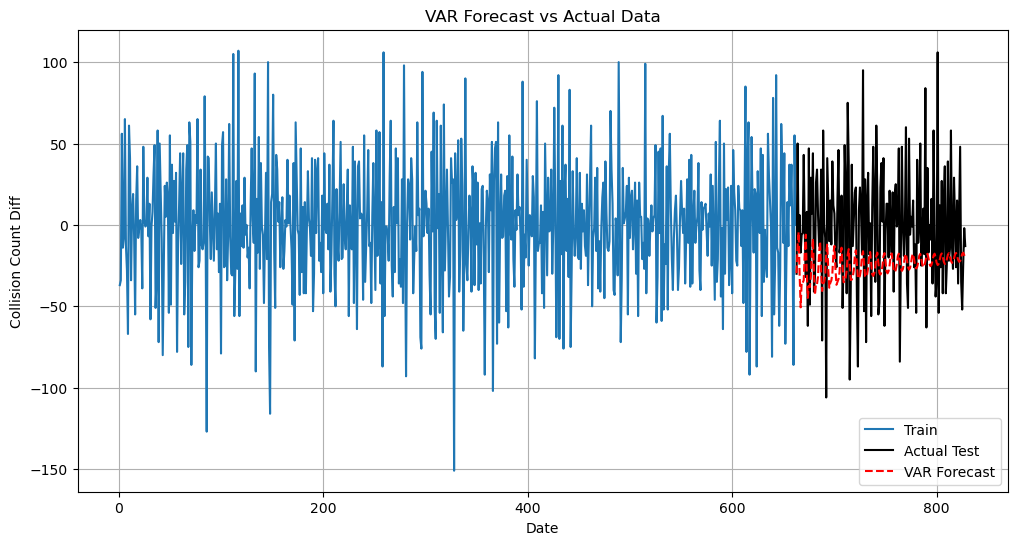

Test RMSE: 35.9861
VAR Model AIC: 9.1435
VAR Model AICc: 23.0799


In [41]:
from sklearn.metrics import mean_squared_error
# Forecast for test set
forecast_steps = len(test)
forecast_diff = var_results.forecast(train.values[-optimal_lag:], steps=forecast_steps)

# Convert forecasted differenced values back to original scale
forecast_original = test["Collision_Count_Diff"].iloc[0] + np.cumsum(forecast_diff[:, 0])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test["Collision_Count_Diff"], forecast_diff[:, 0]))

# Compute AIC and AICc for the fitted VAR model
aic = var_results.aic
n = len(train)
k = len(var_results.params)
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["Collision_Count_Diff"], label="Train")
plt.plot(test.index, test["Collision_Count_Diff"], label="Actual Test", color="black")
plt.plot(test.index[:forecast_steps], forecast_original, label="VAR Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Collision Count Diff")
plt.title("VAR Forecast vs Actual Data")
plt.legend()
plt.grid(True)
plt.show()

# Display results
print(f"Test RMSE: {rmse:.4f}")
print(f"VAR Model AIC: {aic:.4f}")
print(f"VAR Model AICc: {aicc:.4f}")